In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # cuda used for GPU specific stuff, ex. checking availability, etc.
device

device(type='cuda')

# Load datasets for EDA
Load the data sets without transforms since we are only interested in using them for Exploratory Data Analysis (EDA) at this point.

Initialize an instance of the `torchvision.datasets.FashionMNIST` class.
- `root` is the directory containing the data files (or zipped data files, which will need to be unzipped by the `download` keyword argument)
- `train` if set to `True`, indicates training data, as opposed to test data
- `download` if set to True, downloads (unzips) the data, if not already unzipped

In [3]:
train_dataset = datasets.FashionMNIST(root="C:/Projects/fashion-mnist/data/fashion", train=True, download=True)

In [4]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: C:/Projects/fashion-mnist/data/fashion
    Split: Train

The dataset has 10 classes describing articles of clothing.

In [5]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
train_dataset.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Each datapoint is an image with a target, where the target is a number that describes the class the image falls into.

In [7]:
train_dataset.data[0].shape

torch.Size([28, 28])

In [8]:
type(train_dataset.data)

torch.Tensor

In [9]:
train_dataset.targets.bincount()  # Check the distribution of targets

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

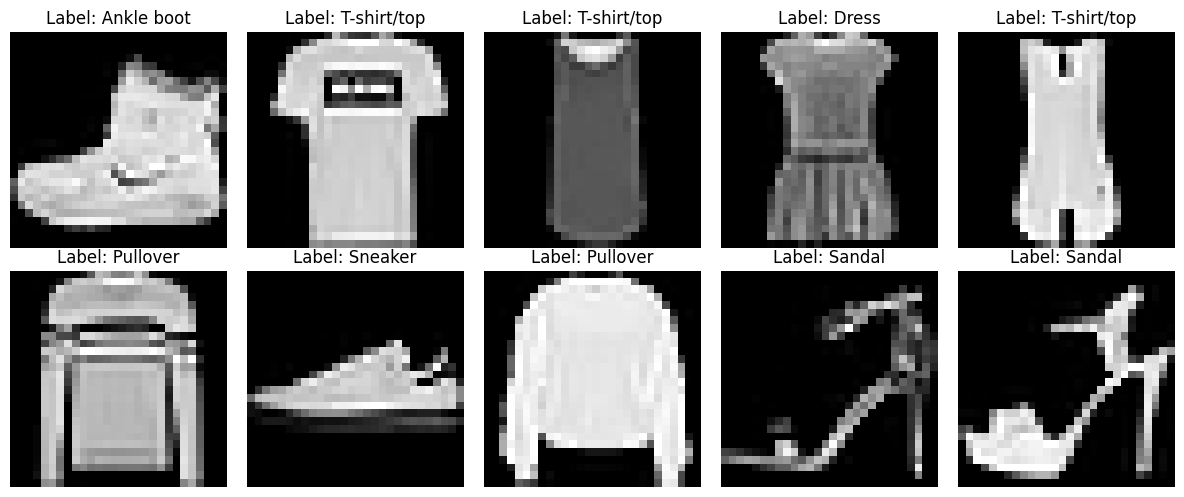

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Label: {train_dataset.classes[label]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Create the Model

In [11]:
# hyperparameters

batch_size = 64
learning_rate = 0.001
num_epochs = 50

In [12]:
# Scales data to have mean 0 and standard deviation 1 for faster convergence.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
# Load the data again. This time, use a dataloader for batching and transforming

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class CNNFashionMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 28x28x1 -> Output: 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 7x7x64
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.fc_layers(x)
        return x

In [15]:
model = CNNFashionMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
losses = []

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backpropagation
        optimizer.zero_grad()  # clear previous gradients
        loss.backward()  # get gradients
        optimizer.step()  # update model parameters (weights and biases)

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, GPU Memory Allocated: {torch.cuda.memory_allocated()} bytes" )
            losses.append(loss.item()))


Epoch [1/50], Step [100/938], Loss: 0.6370, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [200/938], Loss: 0.6030, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [300/938], Loss: 0.4514, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [400/938], Loss: 0.5985, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [500/938], Loss: 0.6672, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [600/938], Loss: 0.3216, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [700/938], Loss: 0.2616, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [800/938], Loss: 0.6730, GPU Memory Allocated: 24716800 bytes
Epoch [1/50], Step [900/938], Loss: 0.4185, GPU Memory Allocated: 24716800 bytes
Epoch [2/50], Step [100/938], Loss: 0.3999, GPU Memory Allocated: 24716800 bytes
Epoch [2/50], Step [200/938], Loss: 0.6908, GPU Memory Allocated: 24716800 bytes
Epoch [2/50], Step [300/938], Loss: 0.3989, GPU Memory Allocated: 24716800 bytes
Epoch [2/50], Step [400/938]

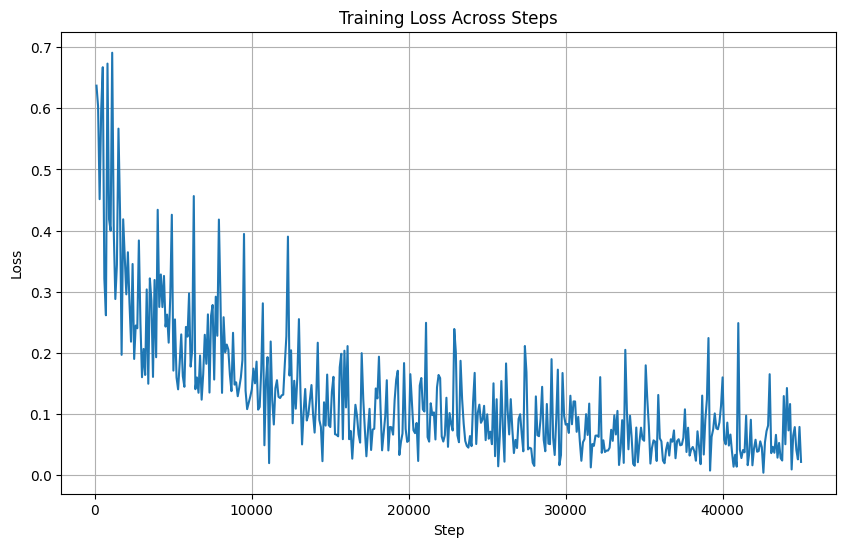

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(100, len(losses)*100+1, 100), losses)
plt.title("Training Loss Across Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()